In [ ]:
import jax.numpy as jnp
from sklearn.metrics import pairwise_kernels
import jax.random as random
from jax import vmap, jit
from functools import partial

In [ ]:
import jax.numpy as jnp
from jax import random, jit, vmap
from functools import partial
import jax

@jit
def rbf_kernel(X, Y, gamma):
    """
    Compute the RBF (Gaussian) kernel between X and Y.
    """
    squared_diff = jnp.sum(X**2, axis=1)[:, None] + jnp.sum(Y**2, axis=1)[None, :] - 2 * jnp.dot(X, Y.T)
    return jnp.exp(-gamma * squared_diff)

@jit
def create_kernel(X, p, prob_kernel_width, x_kernel_width):
    K_pp_gamma = 1.0 / (prob_kernel_width**2)
    K_xx_gamma = 1.0 / (x_kernel_width**2)
    K_pp = rbf_kernel(p[:, None], p[:, None], K_pp_gamma)
    K_xx = rbf_kernel(X, X, K_xx_gamma)
    return K_pp * K_xx

@jit
def ELCE2_estimator(K, err):
    err_expanded = err[:, None]
    K_1 = err_expanded * K * err_expanded.T
    return jnp.sum(K_1) - jnp.sum(jnp.diag(K_1))

@jit
def ELCE2(X, Y, p, prob_kernel_width, x_kernel_width):
    K = create_kernel(X, p, prob_kernel_width, x_kernel_width)
    p_err = Y - p
    return ELCE2_estimator(K, p_err)


def generate_data(key, N, d):
    key, subkey1, subkey2, subkey3 = random.split(key, 4)
    X = random.normal(subkey1, shape=(N, d))
    beta = jnp.ones(d)
    linear_combination = X @ beta
    p = jax.nn.sigmoid(linear_combination)
    Y = random.bernoulli(subkey2, p)

    miscal_beta = jnp.ones(d-1)
    miscal_linear_combination = X[:, :-1] @ miscal_beta
    miscal_p = jax.nn.sigmoid(miscal_linear_combination)
    miscal_Y = random.bernoulli(subkey3, miscal_p)

    return X, Y, p, miscal_Y, miscal_p


def single_bootstrap(key, N, d, prob_kernel_width, x_kernel_width):
    X, Y, p, miscal_Y, miscal_p = generate_data(key, N, d)
    test_value = ELCE2(X, Y, miscal_p, prob_kernel_width, x_kernel_width)
    null_value = ELCE2(X, Y, p, prob_kernel_width, x_kernel_width)
    return test_value, null_value


def test_p_value_type2(key, N, d, bootstrap_runs, prob_kernel_width, x_kernel_width):
    keys = random.split(key, bootstrap_runs)
    test_values, null_values = vmap(single_bootstrap, (0, None, None, None, None))(
        keys, N, d, prob_kernel_width, x_kernel_width
    )
    return jnp.mean(null_values > test_values)

In [ ]:
N = 1000
d = 50
bootstrap_runs = 500
prob_kernel_width = 0.01
x_kernel_width = 0.01
key = random.PRNGKey(0)

p_value = test_p_value_type2(key, N, d, bootstrap_runs, prob_kernel_width, x_kernel_width)
print(f"p-value: {p_value}")

p-value: 0.0


In [ ]:
key = random.PRNGKey(0)
bootstrap_runs=100
N = 1000
d= 10
keys = random.split(key, 2)
X, Y, p, miscal_Y, miscal_p = vmapped_data(N, d, random.split(keys[0],bootstrap_runs))

In [ ]:
X[:,:,:-1].shape

(100, 1000, 9)

In [ ]:
test_value=vmapped_elce(X[:,:,:-1],Y,miscal_p,0.002,0.002)
null_value=vmapped_elce(X[:,:,:-1],Y,p,0.002,0.002)

In [ ]:
jnp.mean(null_value > test_value)

Array(0.45, dtype=float32)

In [ ]:
test_value.shape

(100,)

# New Section

In [ ]:
def create_kernel(X, p, prob_kernel_width):

    K_pp_gamma = 1.0 / (prob_kernel_width**2)
    K_pp_data = p[:, jnp.newaxis]
    K_pp = pairwise_kernels(K_pp_data, K_pp_data, metric="rbf", gamma=K_pp_gamma)
    K_xx = pairwise_kernels(X, X, metric="rbf", gamma=K_pp_gamma)
    K = K_pp * K_xx
    return jnp.array(K)

def ELCE2_estimator(K_xx, err):

    K = (err.flatten() * K_xx.T).T * err.flatten()
    return K.sum() - K.diagonal().sum()

def ELCE2_normalization(K):

    size = K.shape[0]
    return (size - 1.0) * K.sum() / size

def ELCE2_null_estimator(err, K, key):

    idx = random.permutation(key, len(err))
    return ELCE2_estimator(K, err[idx])

vmapped_ELCE2_null_estimator = jit(vmap(ELCE2_null_estimator, (None, None, 0)))

def compute_null_distribution(p_err, K, key, iterations):

    keys = random.split(key, iterations)
    test_null = vmapped_ELCE2_null_estimator(p_err, K, keys)
    return test_null

def ELCE2(X, Y, p, prob_kernel_width, iterations, key):

    K = create_kernel(X, p, prob_kernel_width=prob_kernel_width)
    p_err = Y - p

    test_value = ELCE2_estimator(K, p_err)

    resolution = 1.0 / iterations

    test_null = compute_null_distribution(p_err, K, key, iterations)

    p_value = jnp.max(jnp.array([resolution, resolution * jnp.sum(test_null > test_value)]))

    return p_value

def test_p_value(N, d, iterations, key, prob_kernel_width):
    keys = random.split(key, 2)
    X, Y, p = generate_data(keys[0], N, d)
    p_value = ELCE2(X, Y, p, prob_kernel_width, iterations, keys[1])
    return p_value


def generate_data(key, N, d):
    key, subkey1, subkey2, subkey3 = random.split(key, 4)
    X = random.normal(subkey1, shape=(N, d))
    beta = jnp.ones(d)
    linear_combination = X @ beta
    p = jax.nn.sigmoid(linear_combination)
    Y = random.bernoulli(subkey2, p)

    miscal_beta = jnp.ones(d-1)
    miscal_linear_combination = X[:, :-1] @ miscal_beta
    miscal_p = jax.nn.sigmoid(miscal_linear_combination)
    miscal_Y = random.bernoulli(subkey3, miscal_p)

    return X, Y, miscal_p


In [ ]:
def vectorize_test_p_value(N, d, iterations, key, prob_kernel_width):

    # Generate 1000 keys
    keys = random.split(key, 1000)

    # Compute p-values for 4000 realizations
    p_values = [test_p_value(N, d, iterations, key_, prob_kernel_width) for key_ in keys]

    # Convert to a standard JAX array
    p_values = jnp.array(p_values)

    # Compute the number of times p_value < 0.05
    rate = jnp.sum(p_values > 0.05) / 1000.0

    return rate

In [ ]:
N = 1000
iterations = 1000
random_state = 6733
d_values = [10, 20, 30, 40,50]
prob_kernel_width = 5
key = random.PRNGKey(random_state)

rate = [vectorize_test_p_value(N,d, iterations, key, prob_kernel_width) for d in d_values]
print("Number of p-values > 0.05:", rate)

Number of p-values > 0.05: [Array(0., dtype=float32, weak_type=True), Array(0.001, dtype=float32, weak_type=True), Array(0.012, dtype=float32, weak_type=True), Array(0.051, dtype=float32, weak_type=True), Array(0.15, dtype=float32, weak_type=True)]


In [ ]:
N = 500
iterations = 1000
random_state = 6733
d_values = [10, 20, 30, 40,50]
prob_kernel_width = 5
key = random.PRNGKey(random_state)

rate2 = [vectorize_test_p_value(N,d, iterations, key, prob_kernel_width) for d in d_values]
print("Number of p-values > 0.05:", rate2)

Number of p-values > 0.05: [Array(0.006, dtype=float32, weak_type=True), Array(0.06900001, dtype=float32, weak_type=True), Array(0.24200001, dtype=float32, weak_type=True), Array(0.42600003, dtype=float32, weak_type=True), Array(0.53400004, dtype=float32, weak_type=True)]


Number of p-values > 0.05: [Array(0.595, dtype=float32, weak_type=True), Array(0.77000004, dtype=float32, weak_type=True), Array(0.851, dtype=float32, weak_type=True), Array(0.87700003, dtype=float32, weak_type=True), Array(0.896, dtype=float32, weak_type=True)]


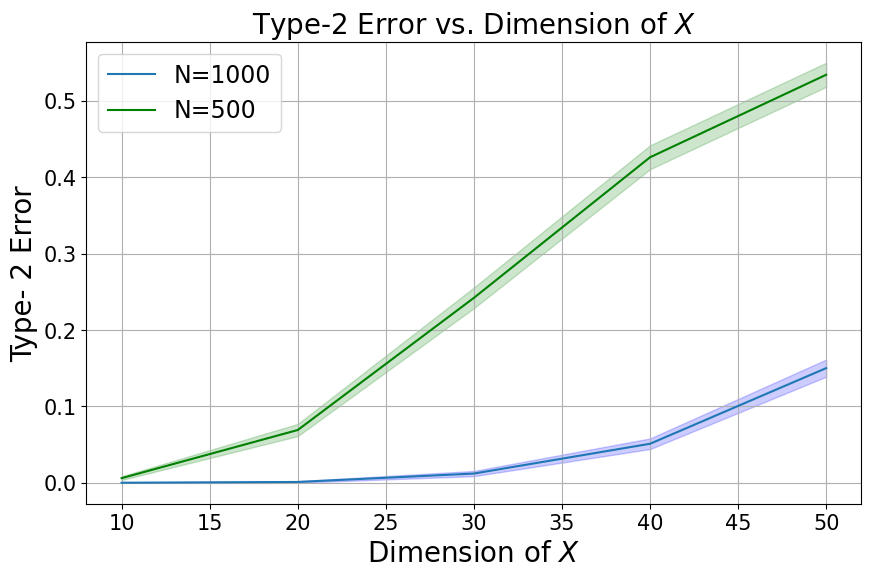

In [ ]:
# prompt: plot a graph of rate against d_values

rate_ = jnp.array(rate)
# Calculate confidence interval
confidence_interval = jnp.sqrt(rate_ * (1.0-rate_) / 1000)

rate_2 = jnp.array(rate2)
# Calculate confidence interval
confidence_interval2 = jnp.sqrt(rate_2 * (1.0-rate_2) / 1000)


import matplotlib.pyplot as plt
# Plotting

plt.figure(figsize=(10, 6))
plt.plot(d_values, rate,label ="N=1000")

plt.fill_between(d_values, rate_ - confidence_interval, rate_ + confidence_interval,
                 color='b', alpha=0.2)

plt.plot(d_values, rate2,label ="N=500",color='g')
plt.fill_between(d_values, rate_2 - confidence_interval2, rate_2 + confidence_interval2,
                 color='g', alpha=0.2)

# Add legend
plt.legend(fontsize=17)
# Show plot
plt.grid(True)
# Increase font size for tick labels
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel("Dimension of $X$",fontsize=20)
plt.ylabel("Type- 2 Error",fontsize=20)
plt.title("Type-2 Error vs. Dimension of $X$",fontsize=20)
plt.show()


In [ ]:
vectorize_test_p_value(100,10, iterations, key, 5)

Array(0.595, dtype=float32, weak_type=True)

In [ ]:
key = random.PRNGKey(0)
bootstrap_runs=100
N = 1000
d= 10
X, Y, p, miscal_Y, miscal_p = generate_data(key, N, d)

In [ ]:
random_state = 6733
key = random.PRNGKey(random_state)
ELCE2(X, Y, miscal_p, 1, 1000, key)

Array(0.001, dtype=float32)